In [1]:
from lucanode.models.unet import Unet
from lucanode.loader import LunaSequence
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from skimage import measure
%matplotlib inline

/home/ofont/miniconda3/envs/lucanode/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Uncomment if you don't want to use the GPU for predictions
#import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [3]:
BASE_DATASET_PATH = Path("/mnt/Data/LUNA/")
UNET_WEIGHTS_FILE = BASE_DATASET_PATH / "unet_3ch_axial_400x400_b72ace7.h5"
NUMPY_ARRAY_FILE = BASE_DATASET_PATH / "nodule_slices_arr_400x400.npy"
METADATA_CSV_FILE = BASE_DATASET_PATH / "nodule_slices_metadata.csv"
BATCH_SIZE=5

In [4]:
model = Unet(400, 400)
model.load_weights(UNET_WEIGHTS_FILE)

In [5]:
df = pd.read_csv(METADATA_CSV_FILE)
df = df[df["plane"] == "axial"]
slices_arr = np.load(str(NUMPY_ARRAY_FILE), mmap_mode='r')
test_idx_split = int(len(df) * 0.9)
test_df = df[(df["export_idx"] > test_idx_split)]

In [6]:
test_sequence = LunaSequence(test_df, slices_arr, BATCH_SIZE, do_augmentation=False)
results = model.predict_generator(test_sequence, verbose=1)

888/888 [==============================] - 212s 239ms/step


In [7]:
def display_results(idx, input_slices, output_slices, predicted_slices, ax):
    ax.imshow(input_slices[idx, :, :], cmap="gray")
    contours_true = measure.find_contours(output_slices[idx, :, :], 0.8)
    contours_pred = measure.find_contours(predicted_slices[idx, :, :], 0.8)
    for n, contour in enumerate(contours_true):
        ax.plot(contour[:, 1], contour[:, 0], linewidth=1, color='b', alpha=0.9)
    for n, contour in enumerate(contours_pred):
        ax.plot(contour[:, 1], contour[:, 0], linewidth=1, color='r', alpha=0.9)
    truth_handle = mlines.Line2D([], [], color='b', label='ground truth')
    pred_handle = mlines.Line2D([], [], color='r', label='prediction')
    ax.legend(handles=[truth_handle, pred_handle])

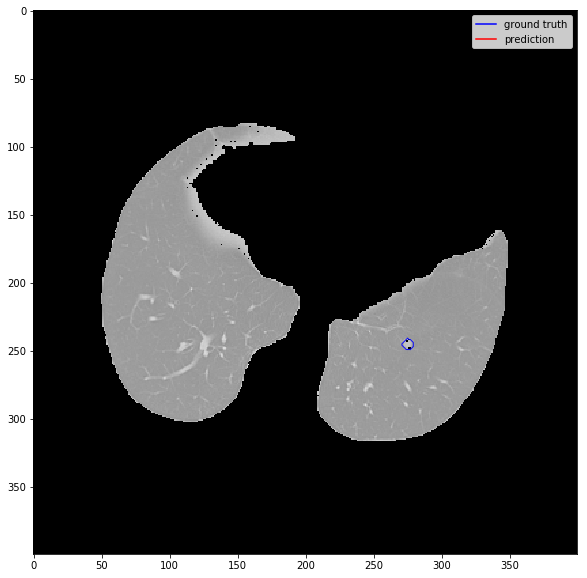

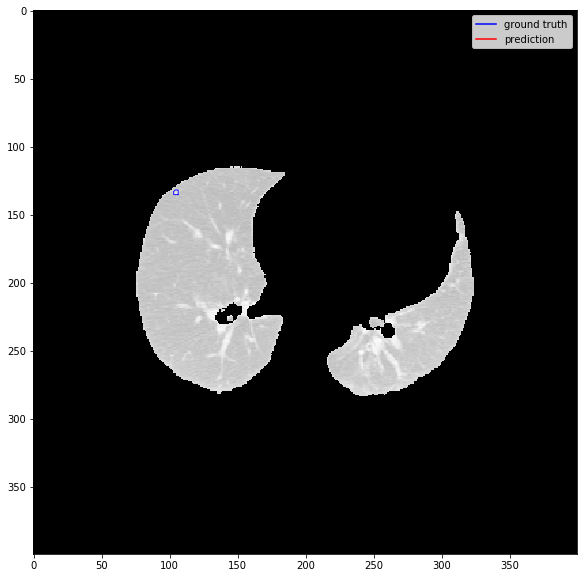

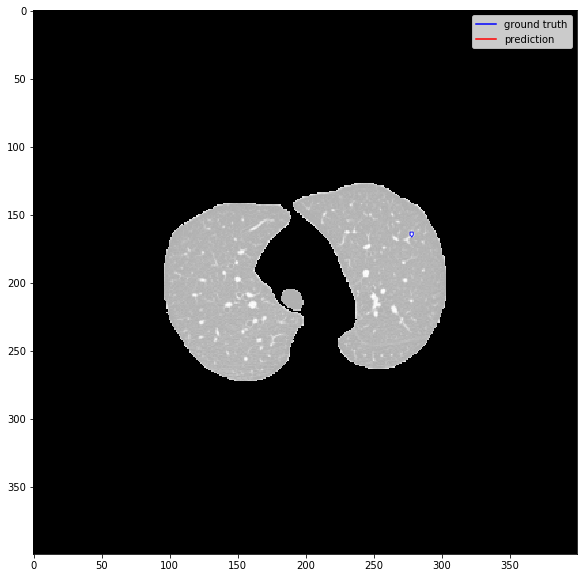

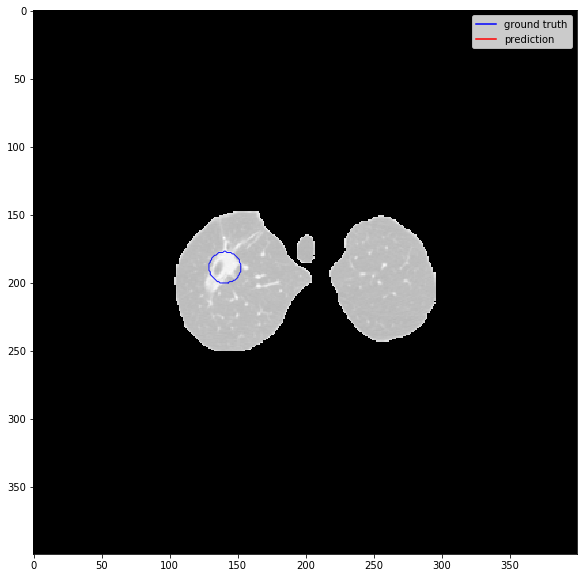

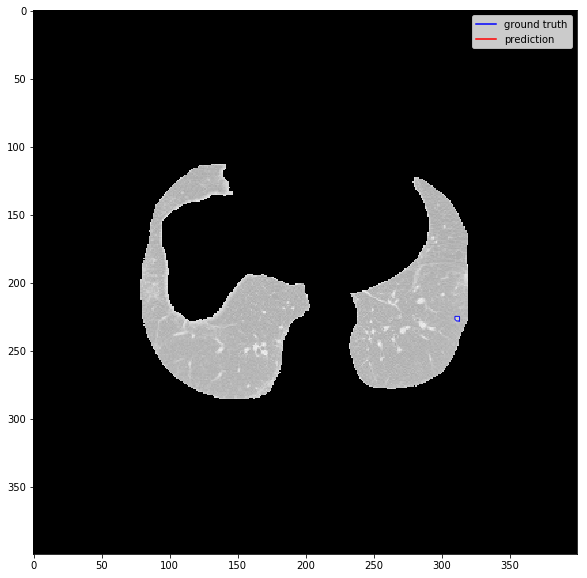

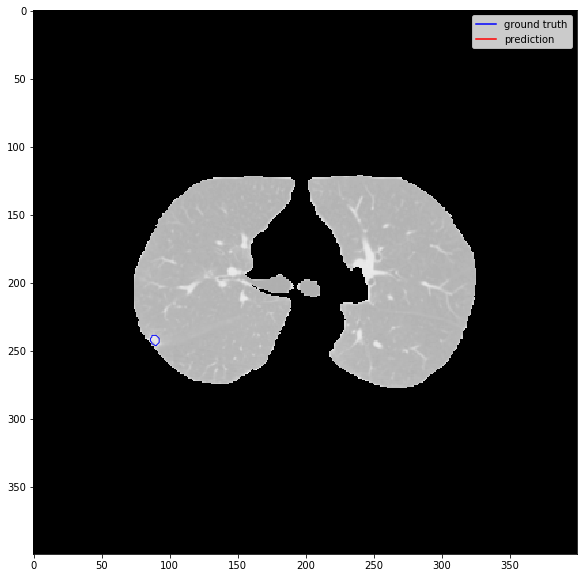

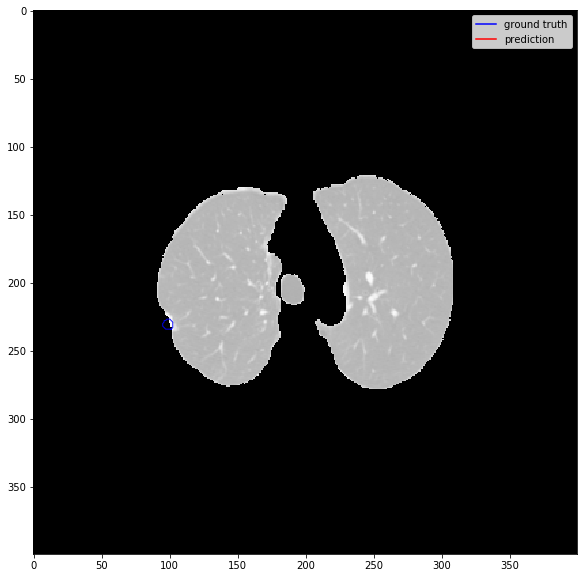

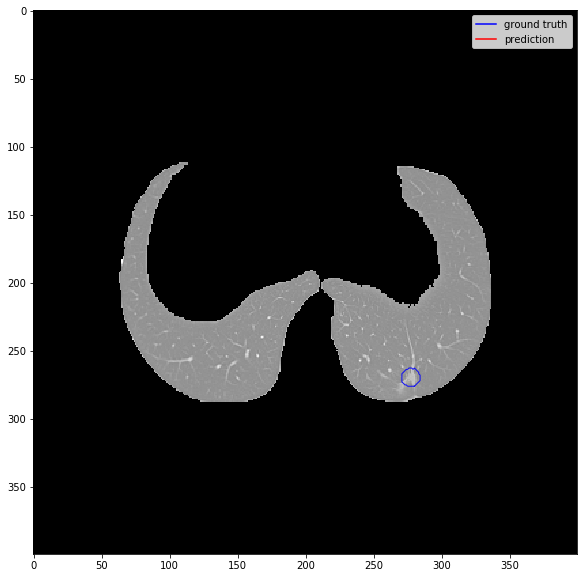

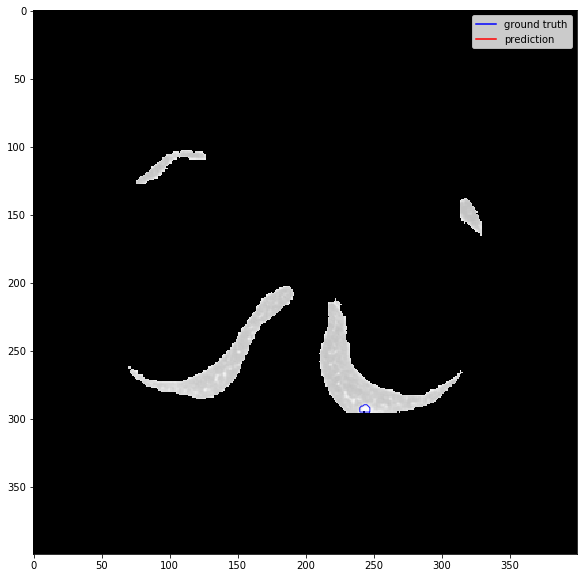

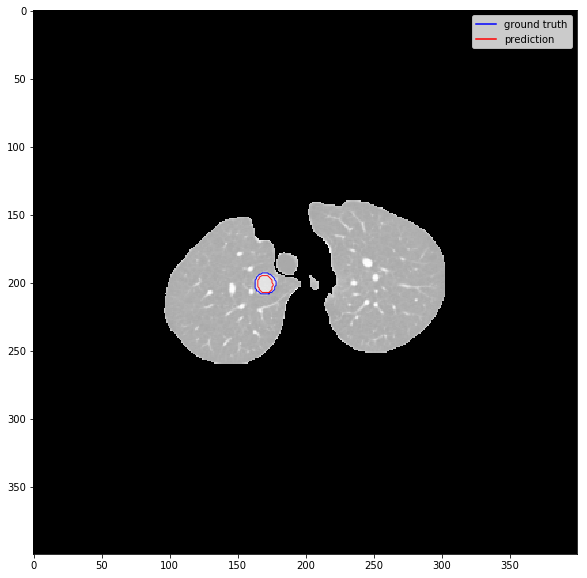

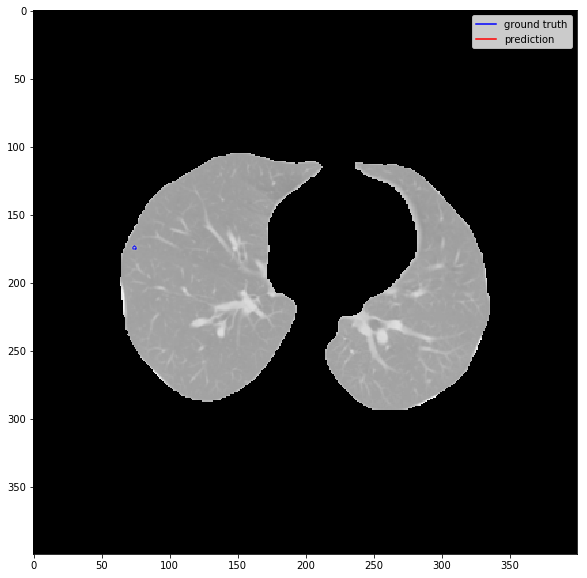

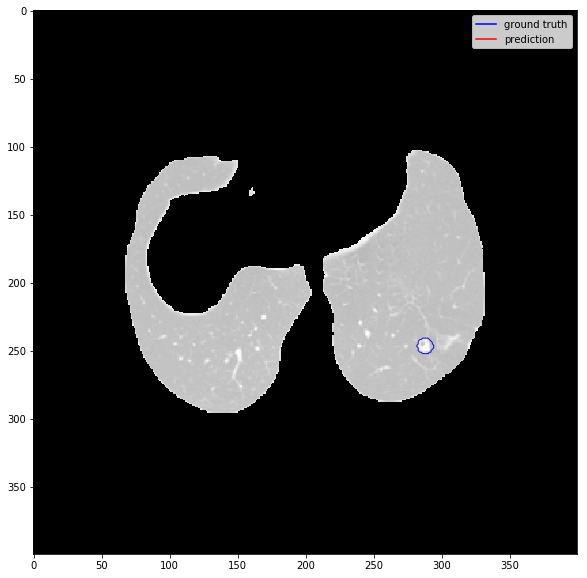

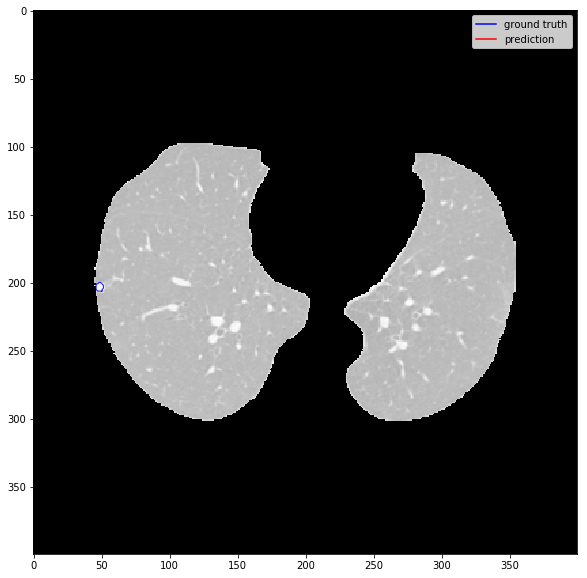

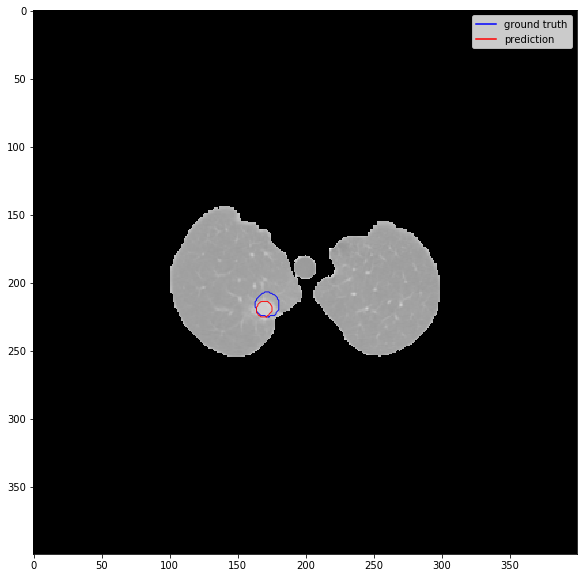

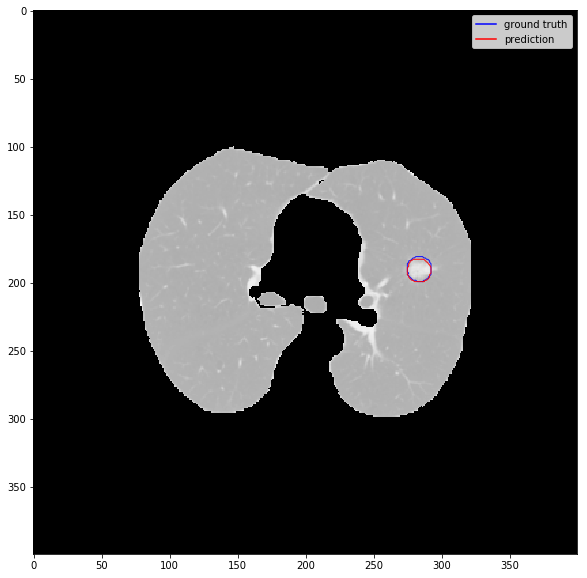

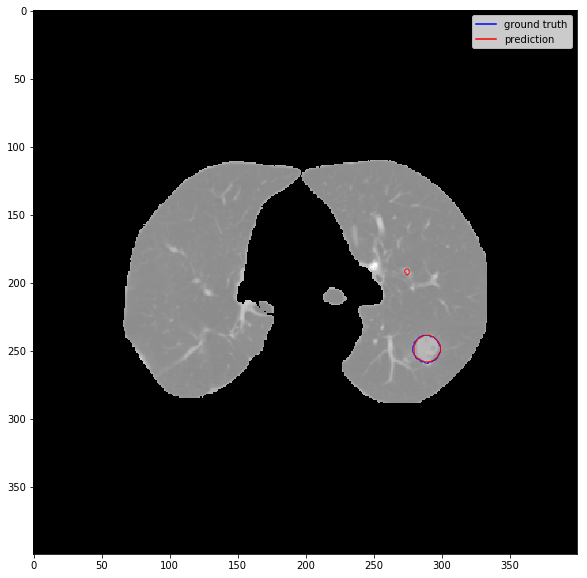

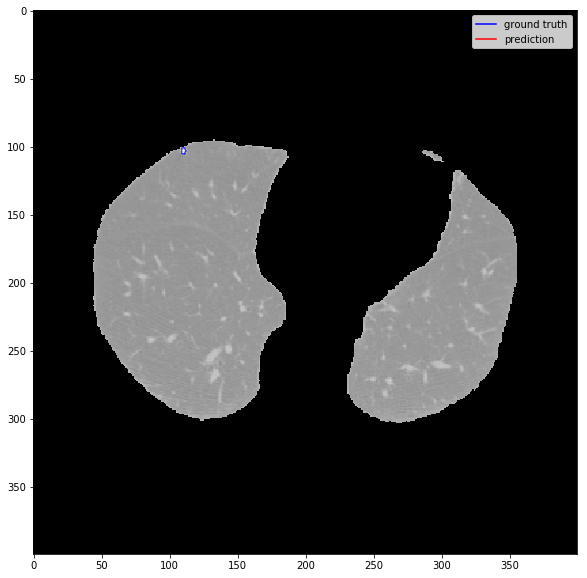

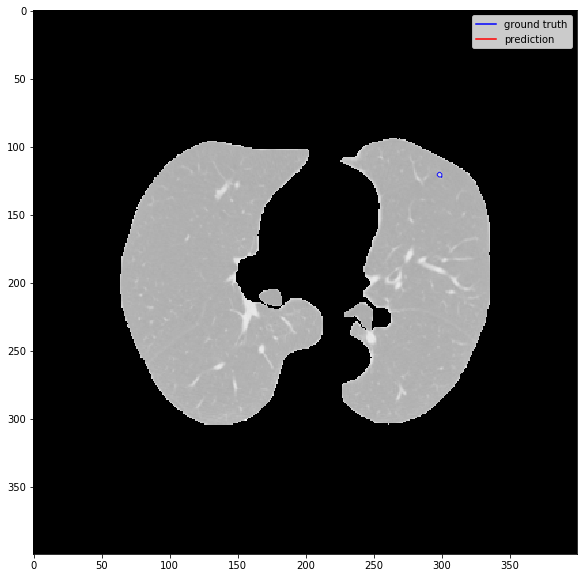

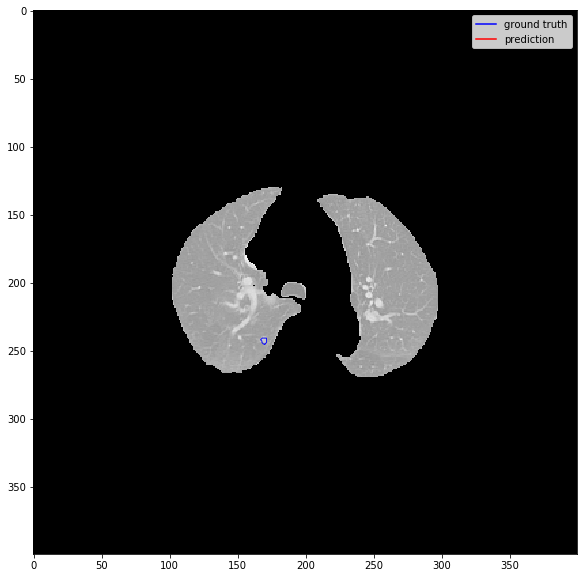

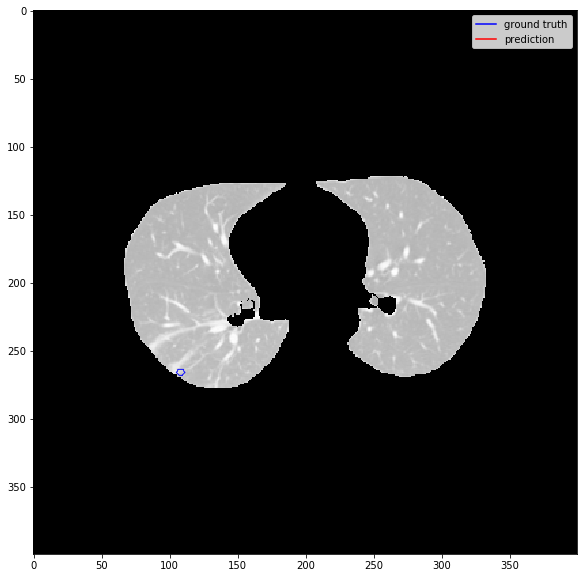

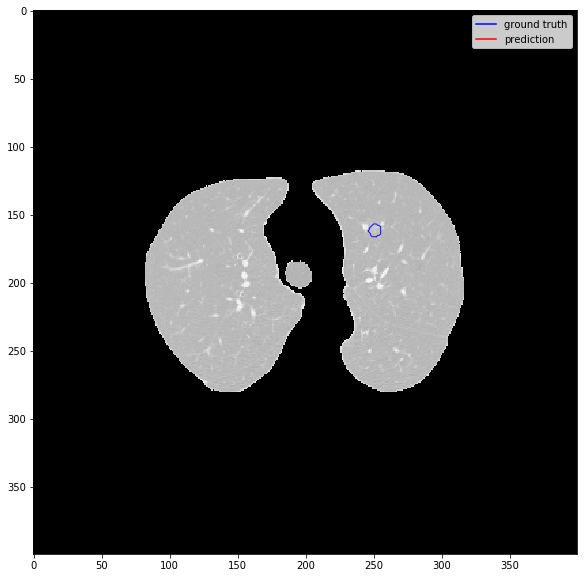

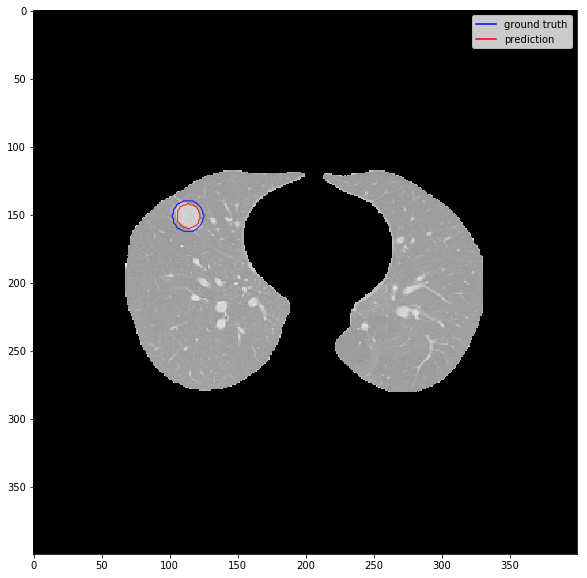

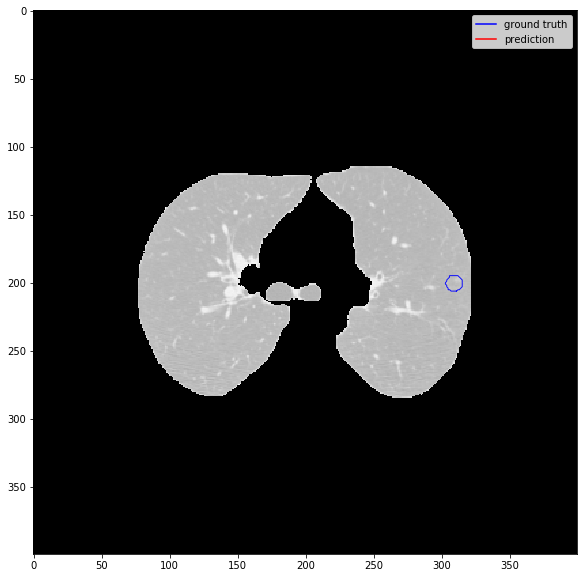

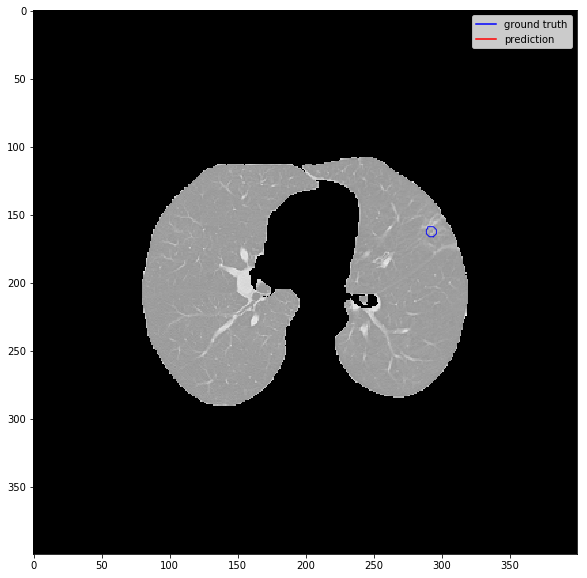

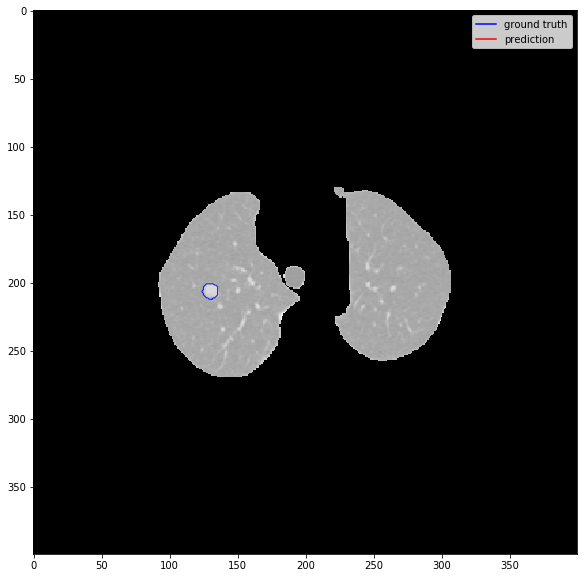

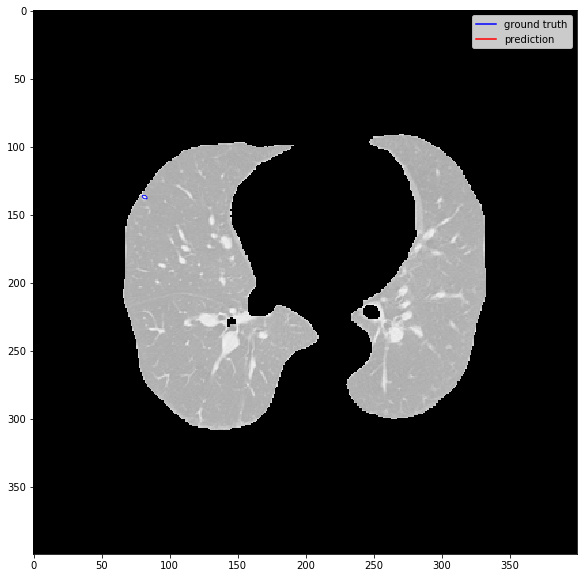

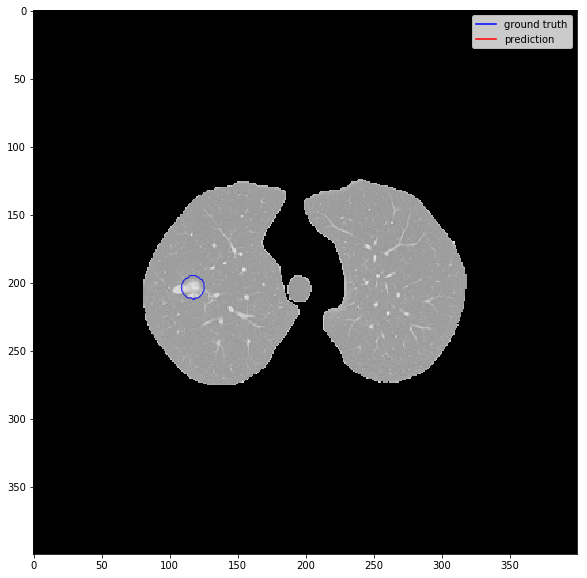

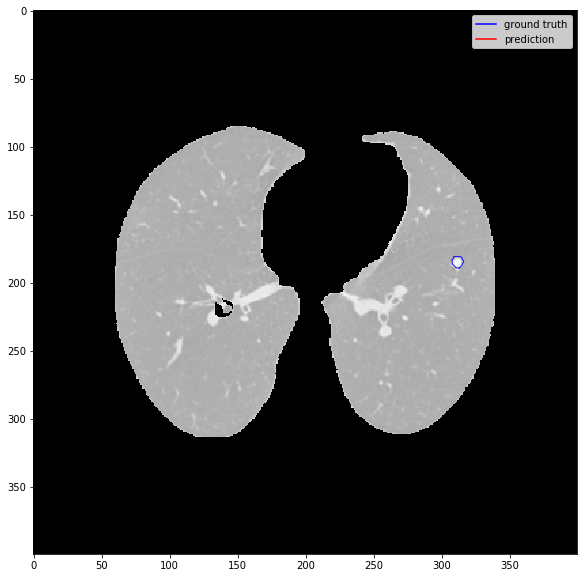

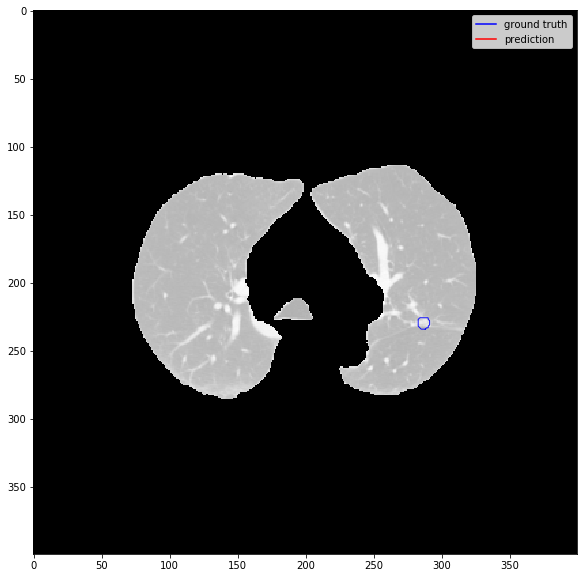

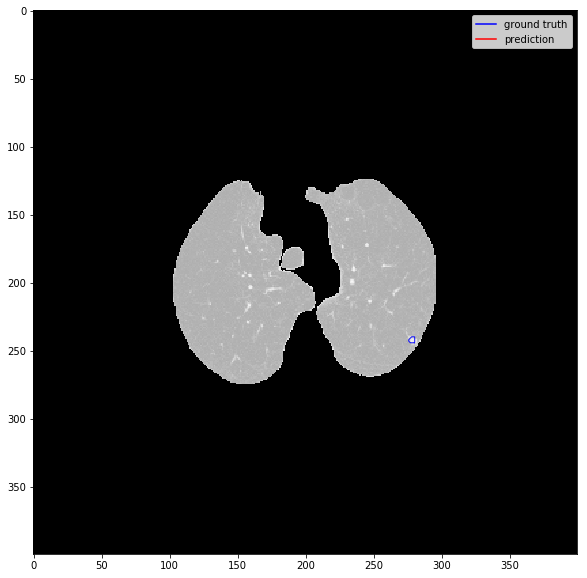

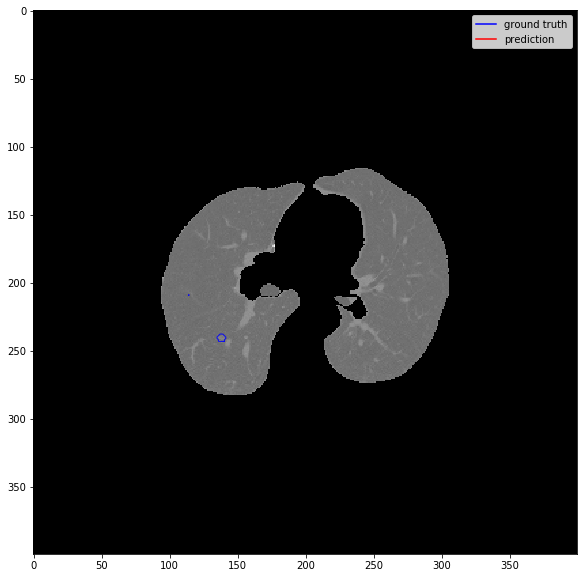

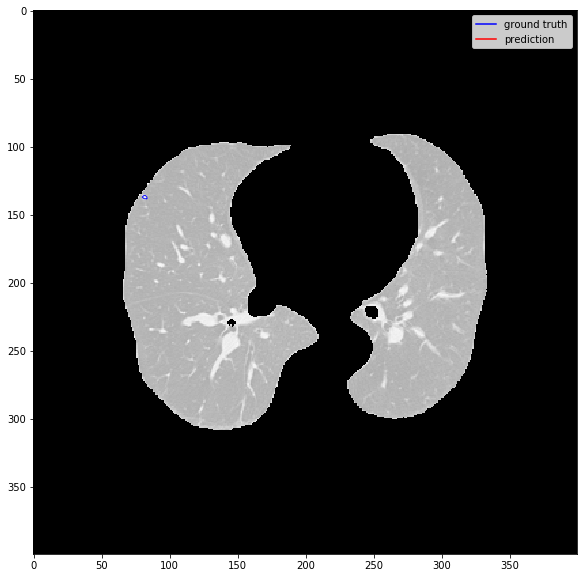

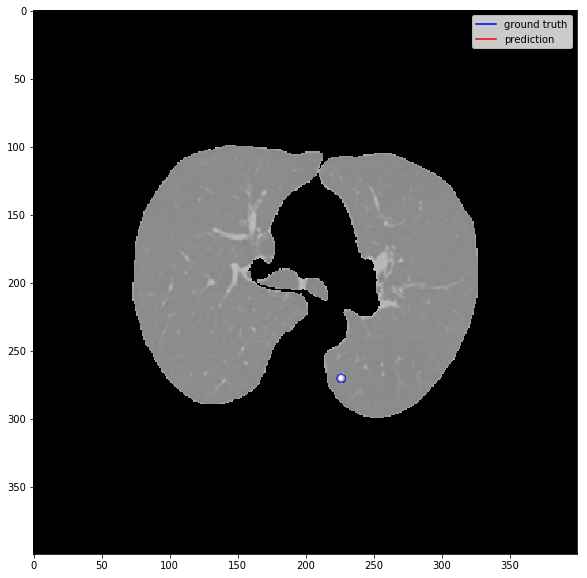

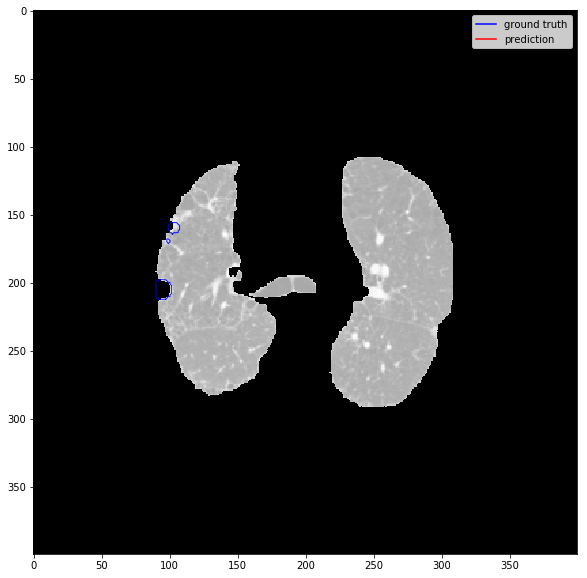

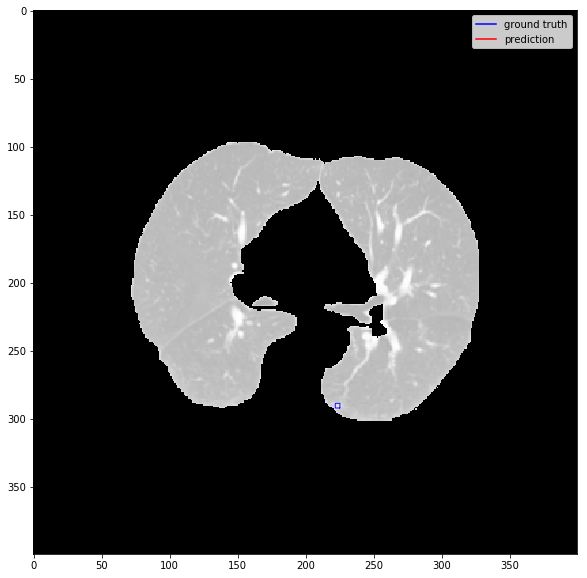

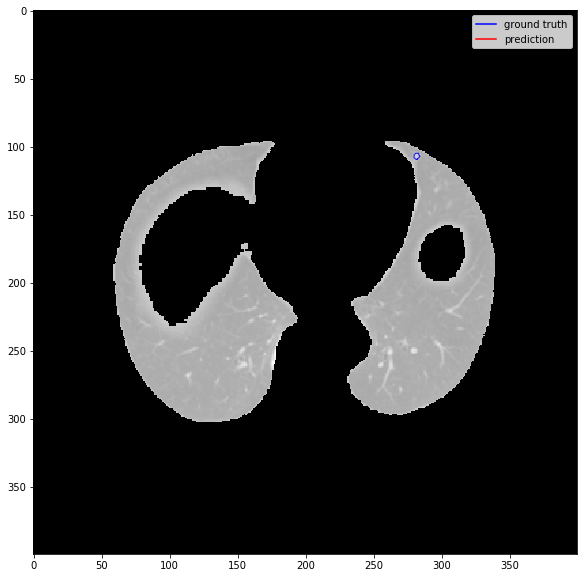

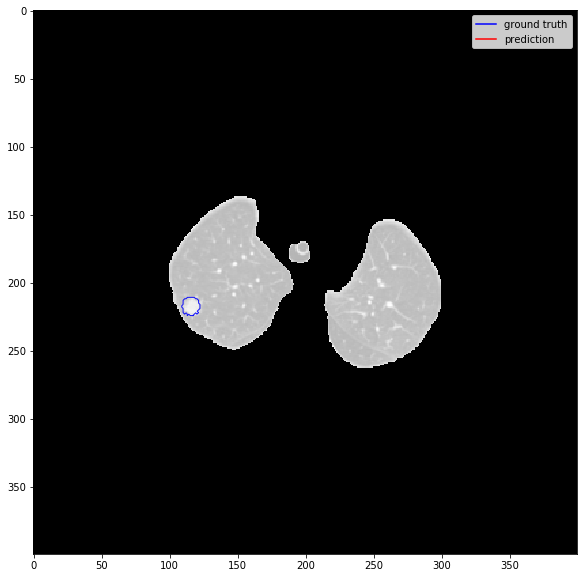

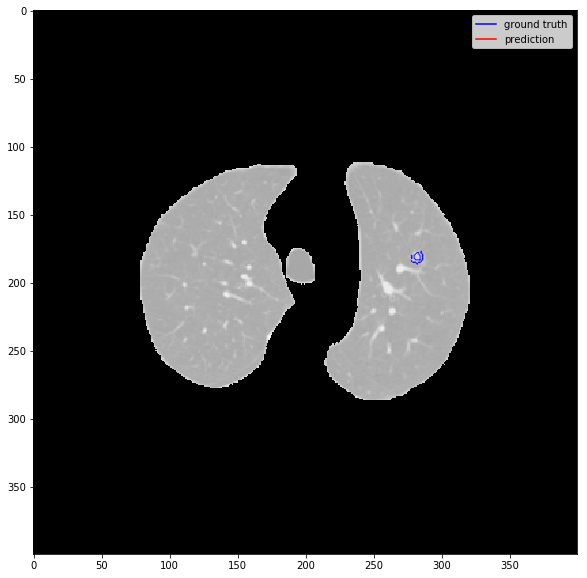

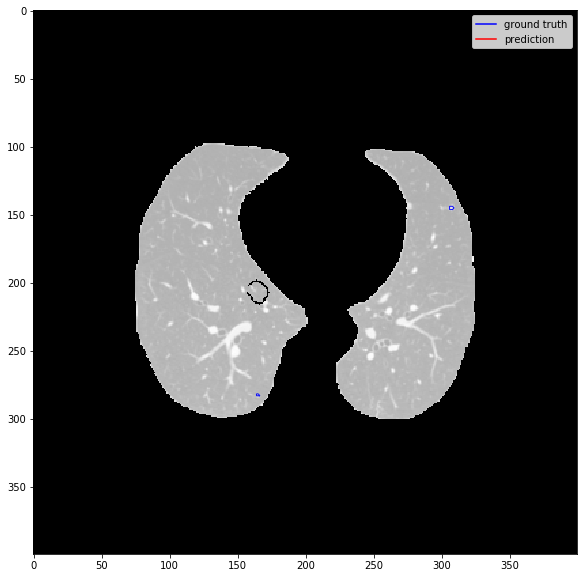

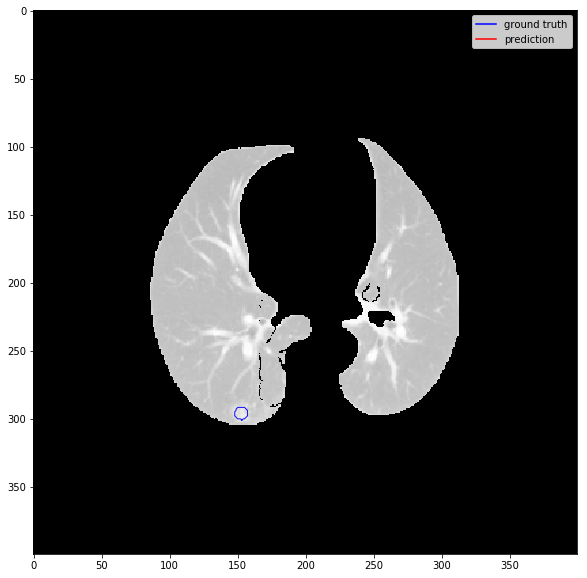

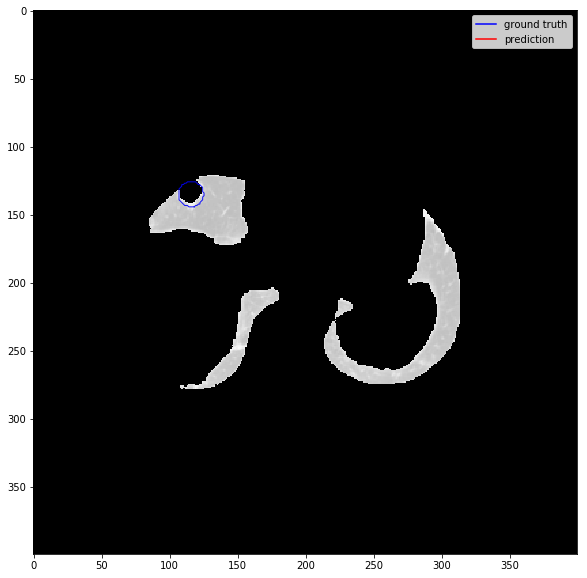

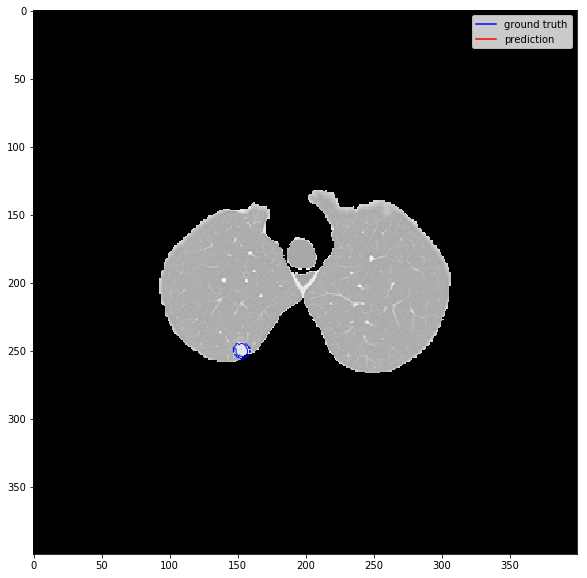

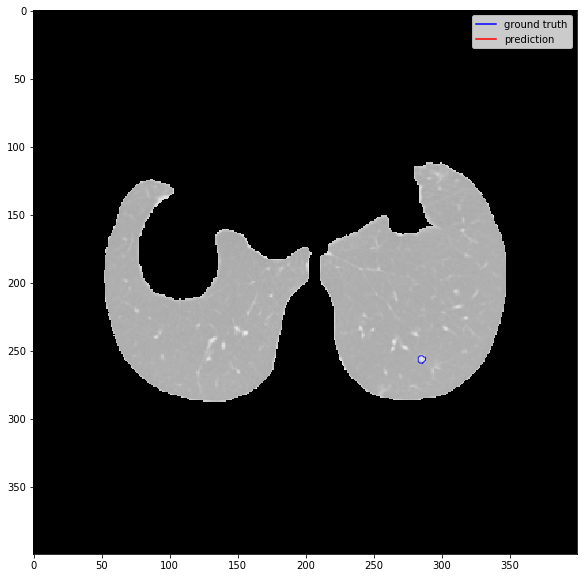

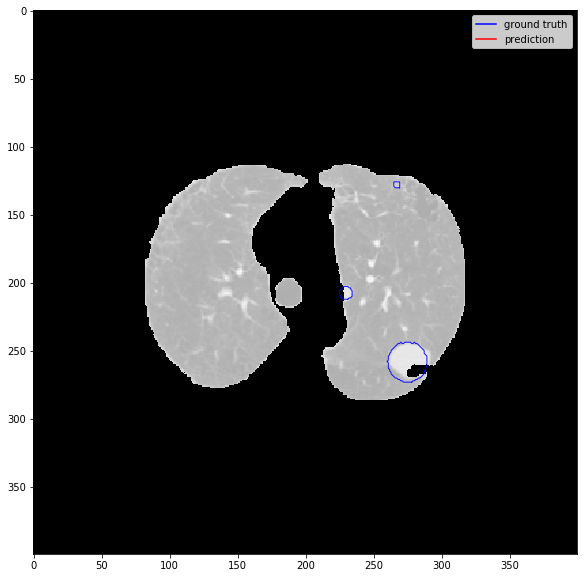

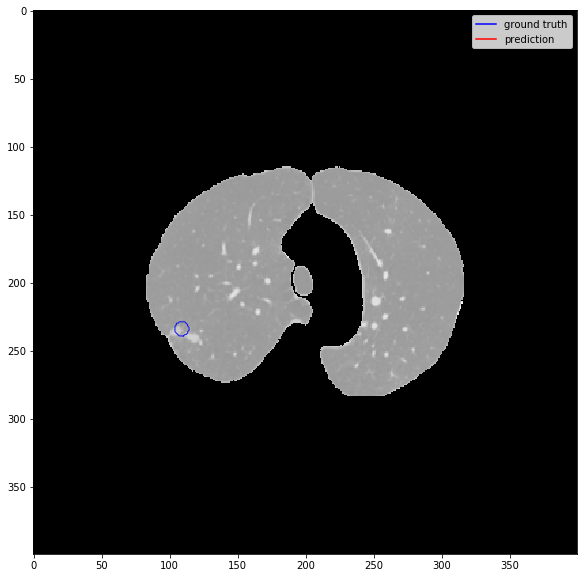

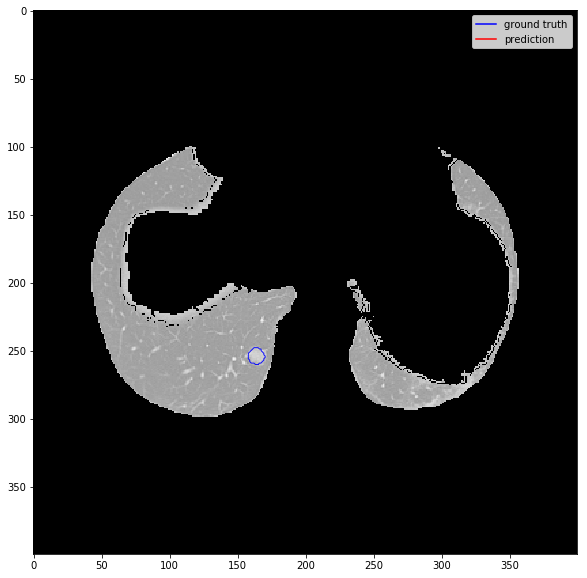

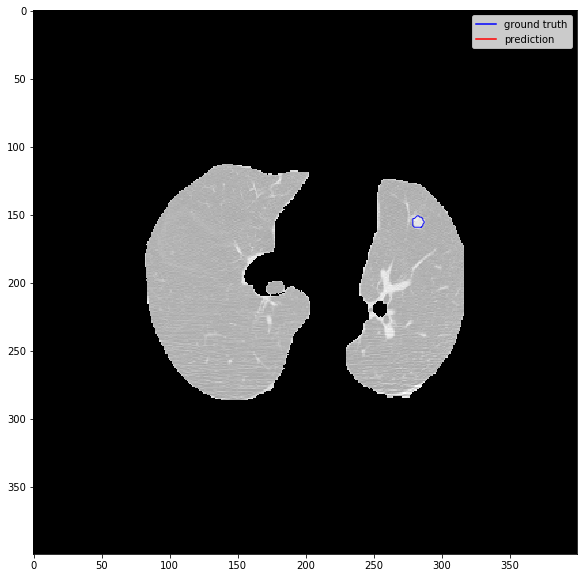

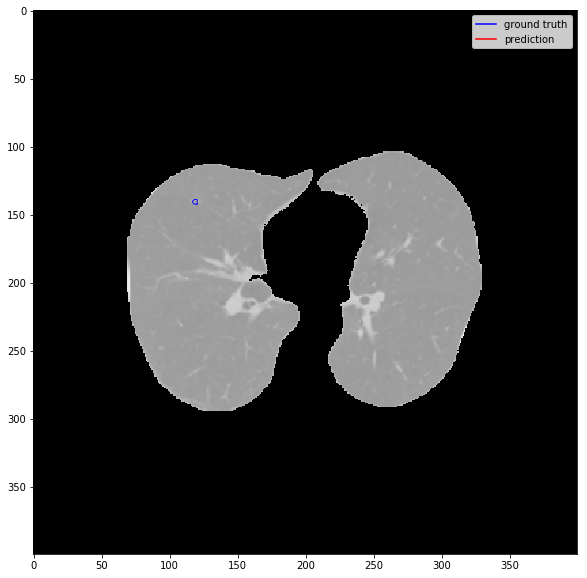

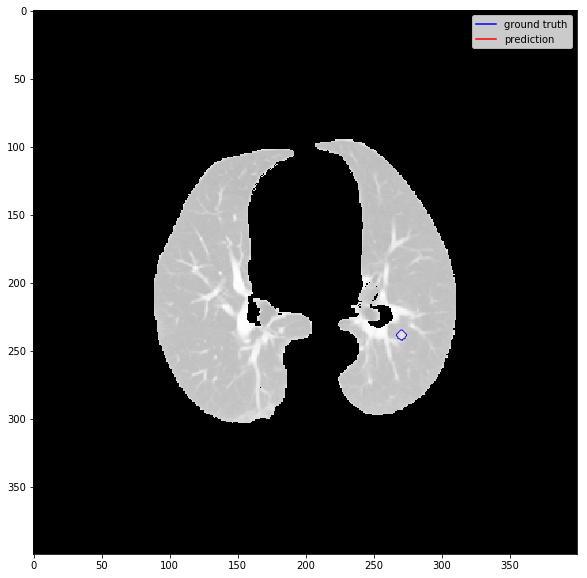

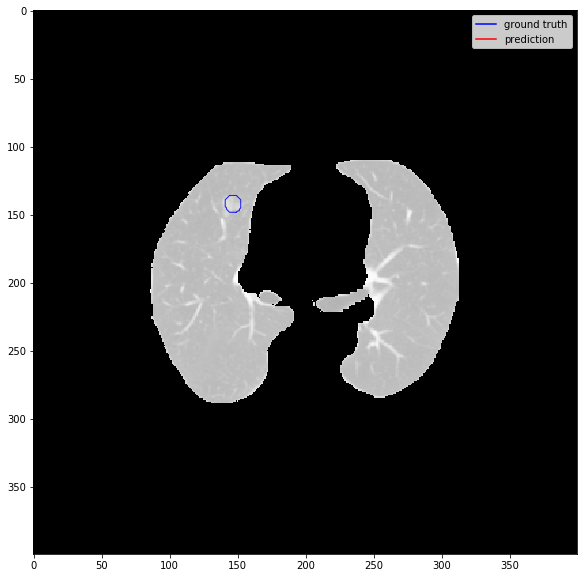

In [8]:
for seq in range(10):
    for n in range(BATCH_SIZE):
        plt.figure(figsize=(10,10))
        input_slices = test_sequence[seq][0][:, :, :, 1]
        output_slices = test_sequence[seq][1][:, :, :, 1]
        res_batch = results[seq*BATCH_SIZE:(seq+1)*BATCH_SIZE, :, :, 0]
        display_results(n, input_slices, output_slices, res_batch, plt)
        plt.show()

In [9]:
np.histogram(results[3, :, :, :], bins=20)

(array([ 26146,   1041,    567,    641,   3137, 113510,   6198,   3723,
          2494,    981,    215,    524,    147,    477,     83,     59,
            32,     16,      6,      3]),
 array([4.57589399e-29, 3.82489485e-11, 7.64978969e-11, 1.14746845e-10,
        1.52995794e-10, 1.91244742e-10, 2.29493691e-10, 2.67742639e-10,
        3.05991588e-10, 3.44240536e-10, 3.82489485e-10, 4.20738433e-10,
        4.58987381e-10, 4.97236330e-10, 5.35485278e-10, 5.73734227e-10,
        6.11983175e-10, 6.50232124e-10, 6.88481072e-10, 7.26730021e-10,
        7.64978969e-10]))

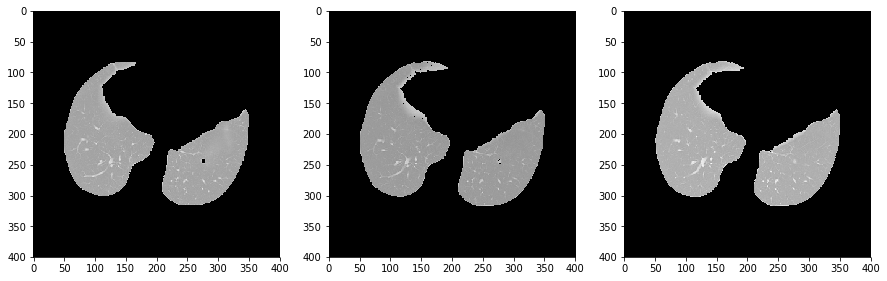

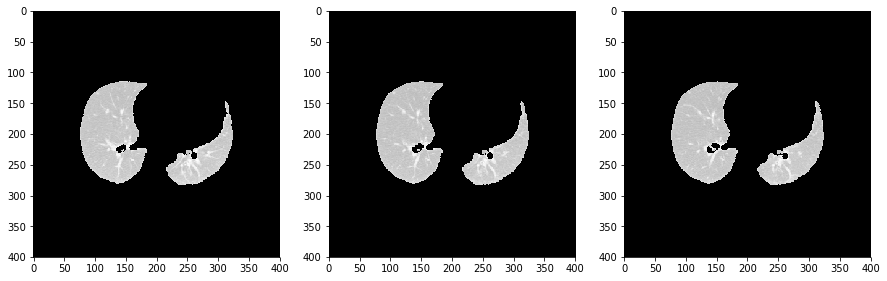

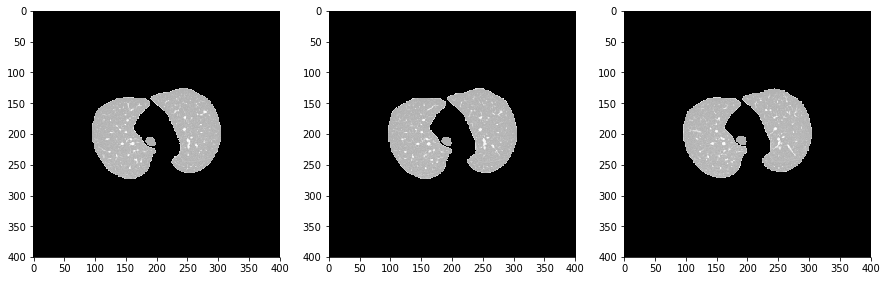

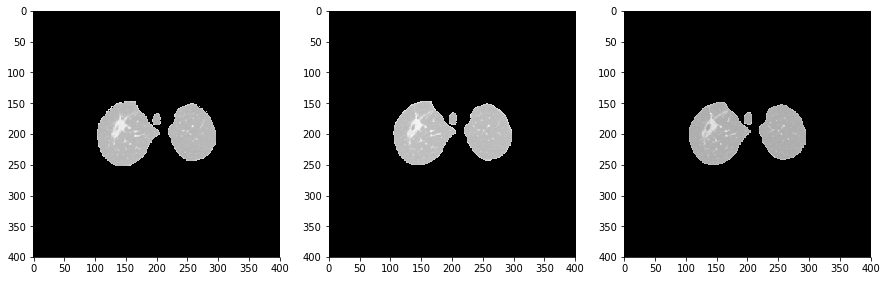

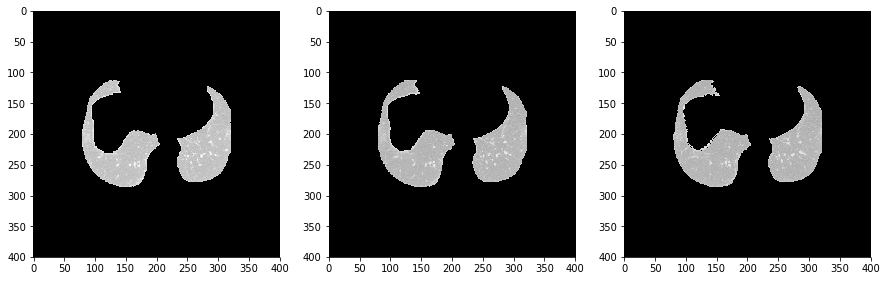

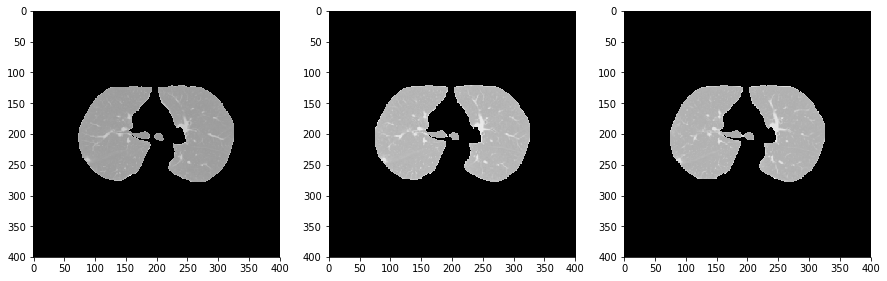

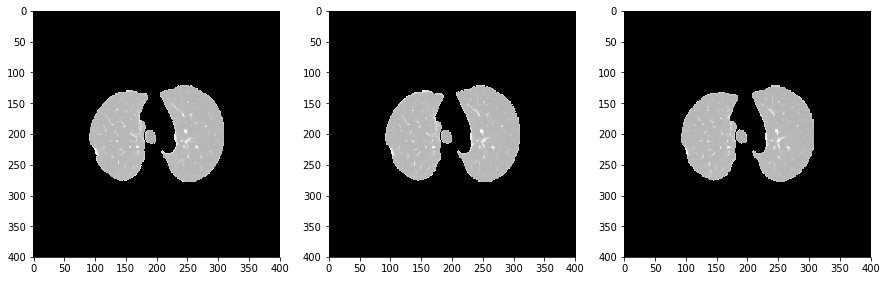

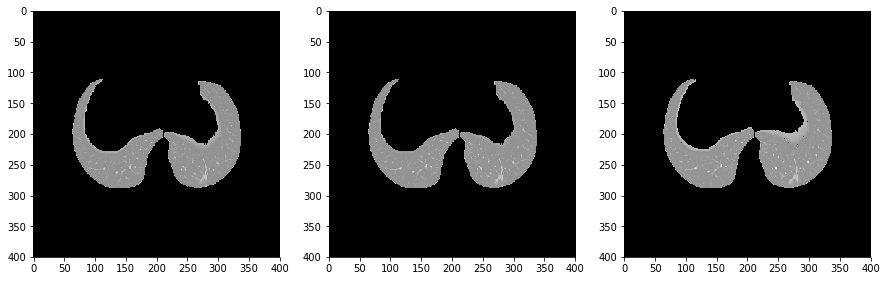

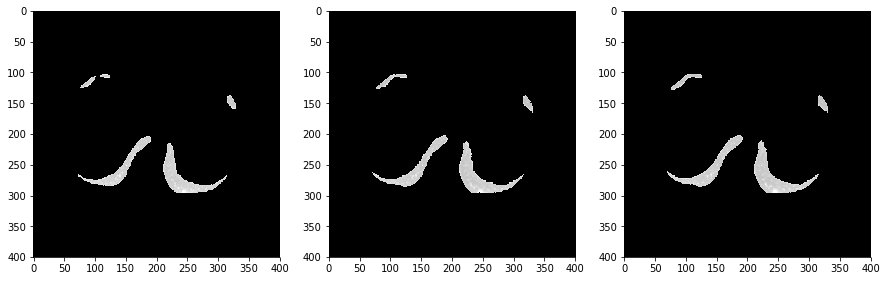

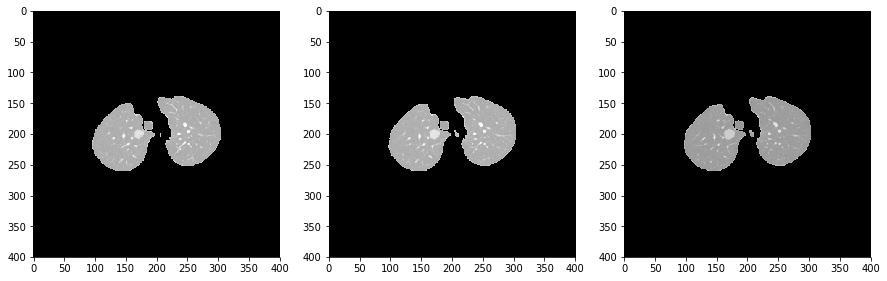

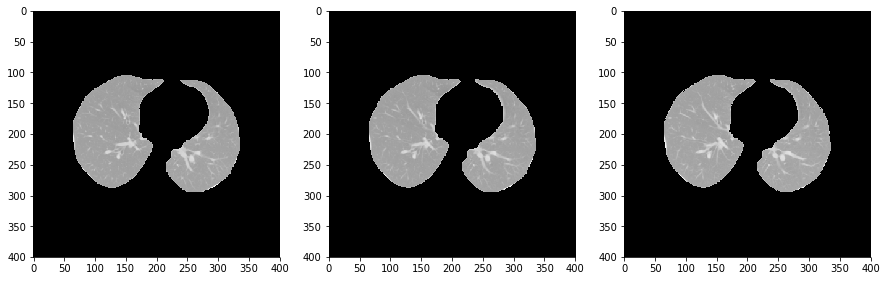

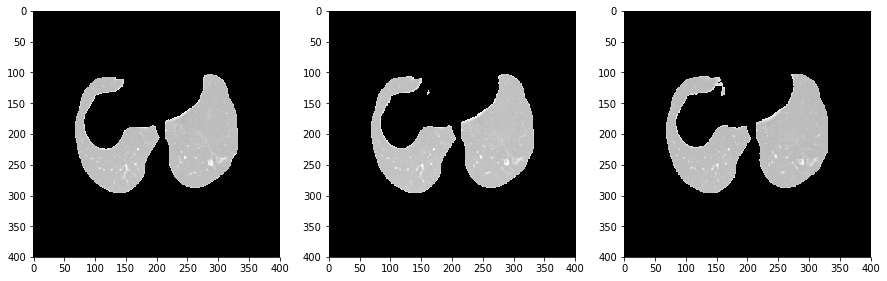

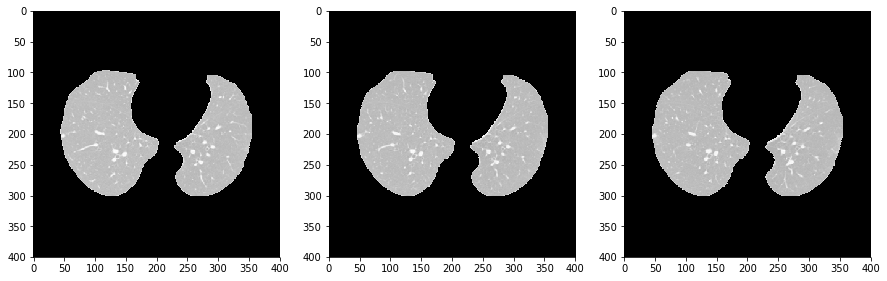

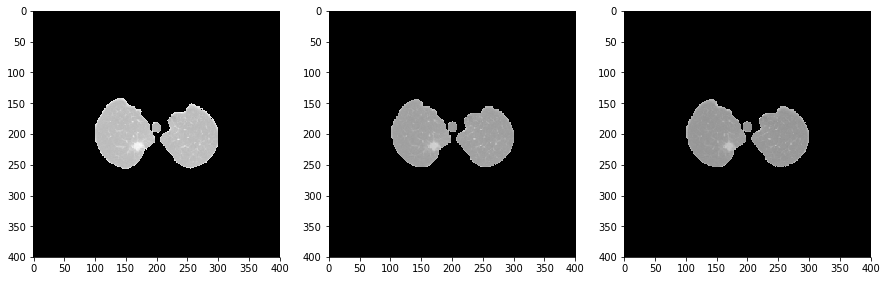

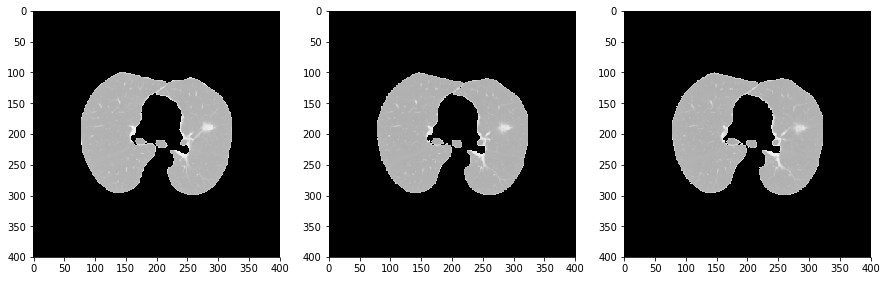

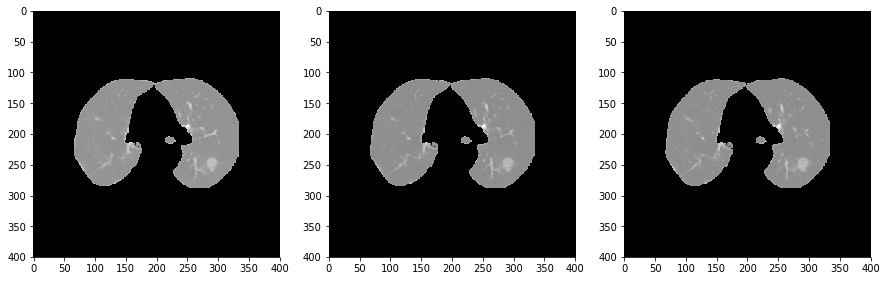

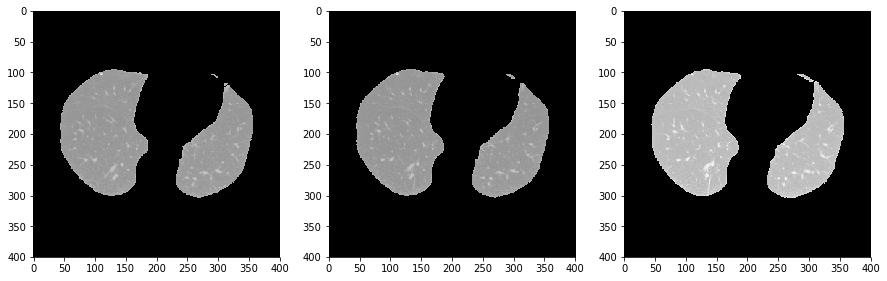

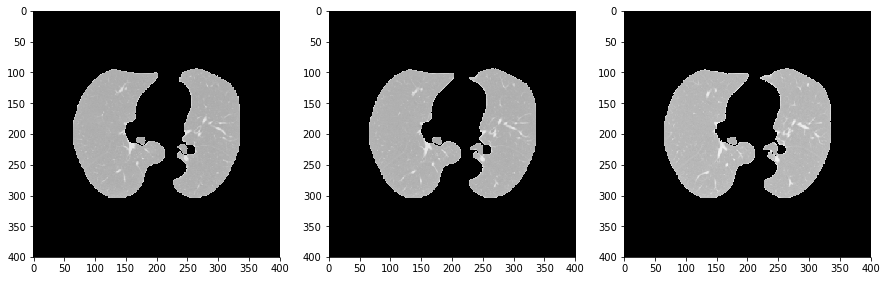

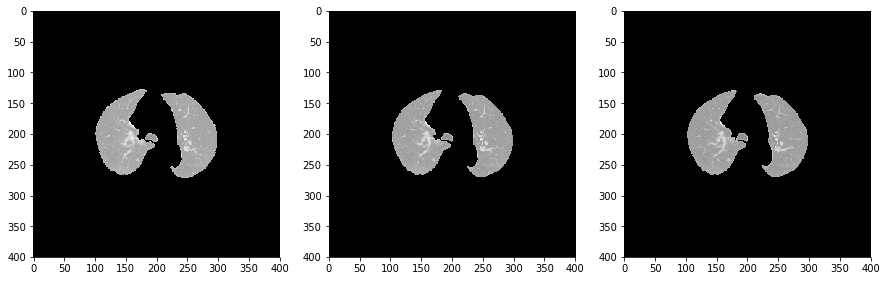

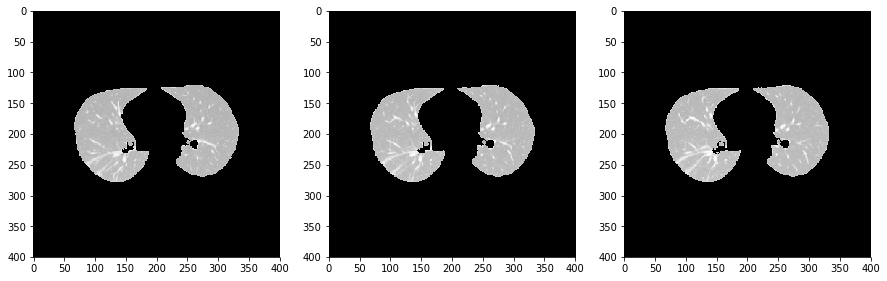

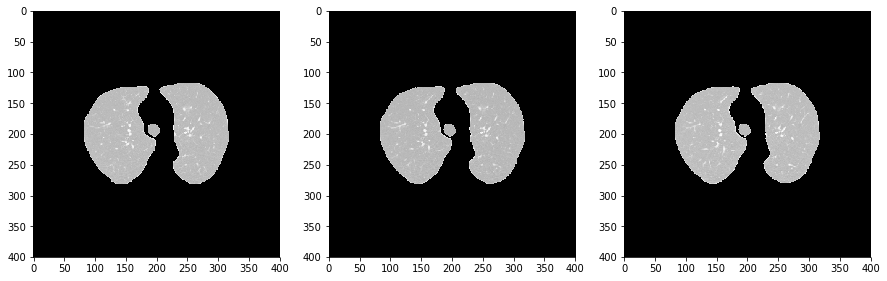

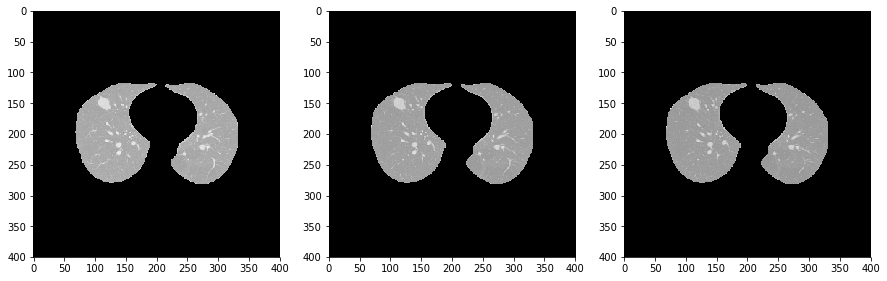

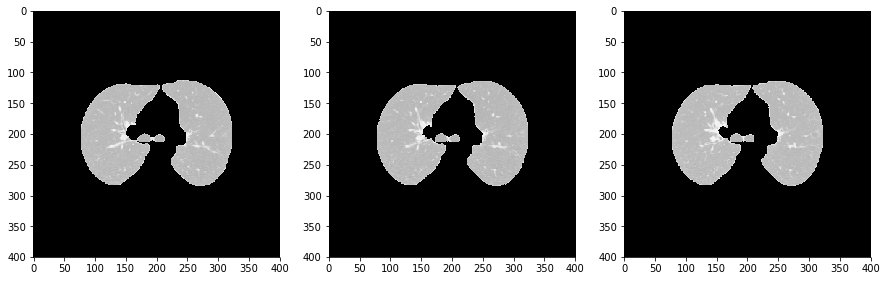

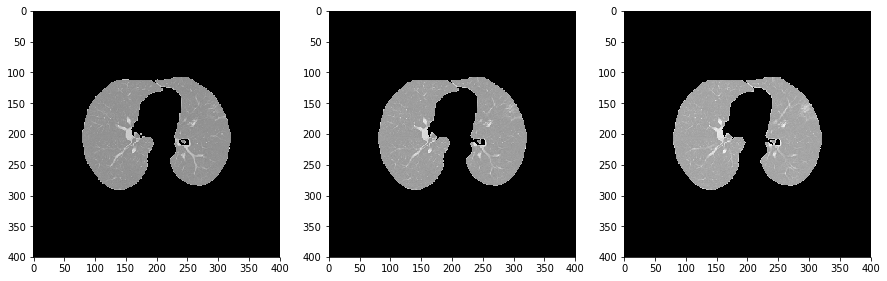

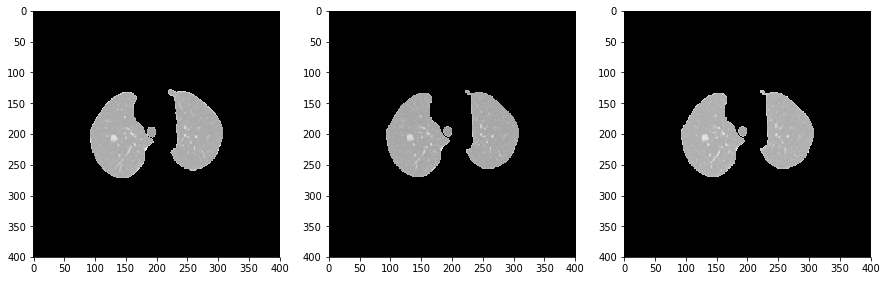

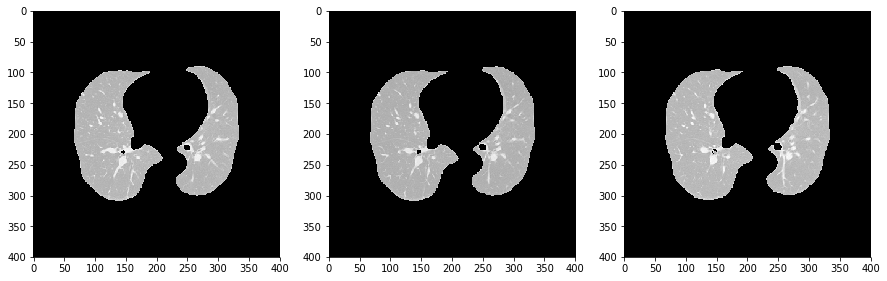

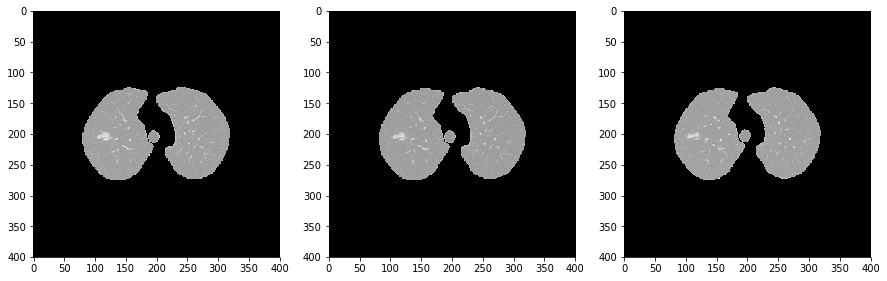

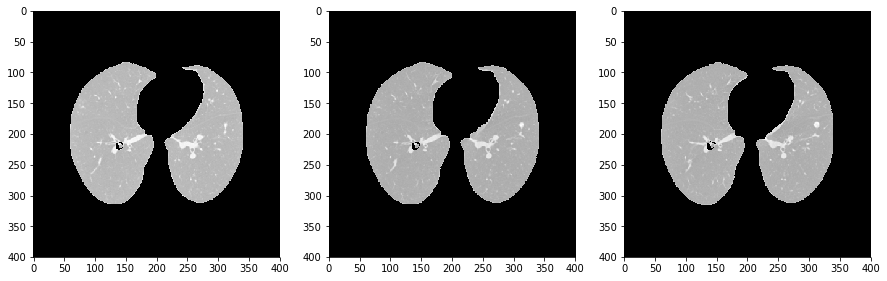

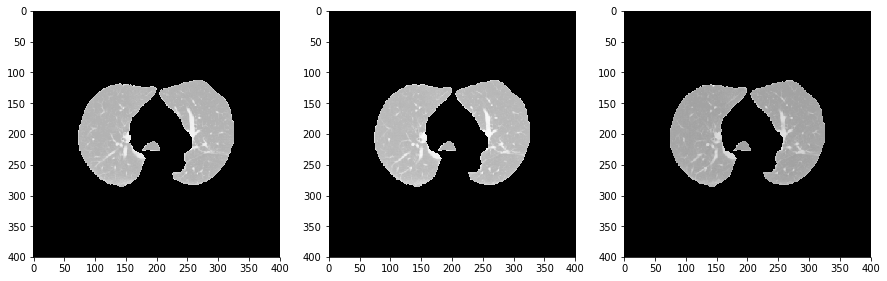

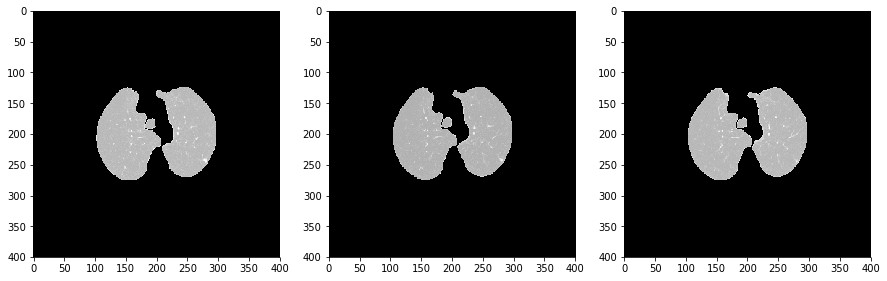

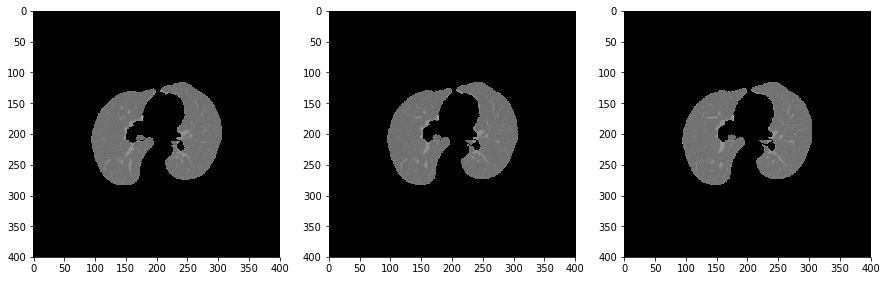

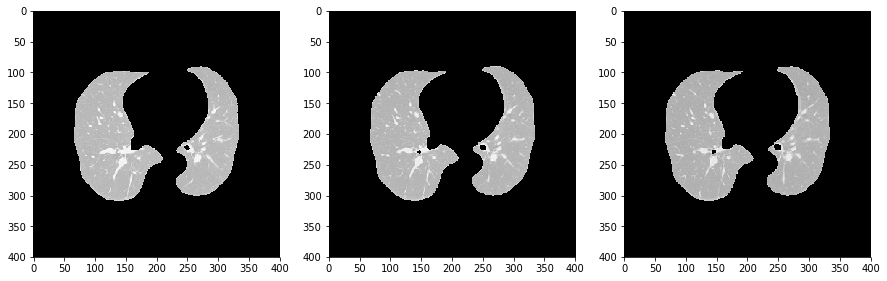

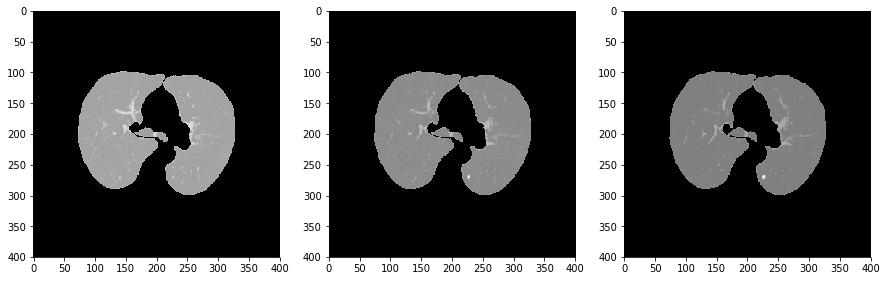

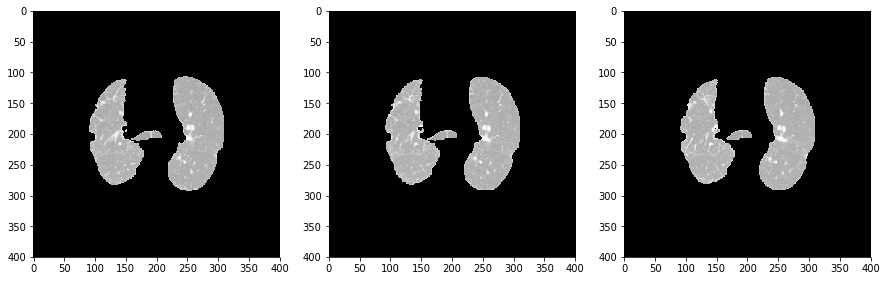

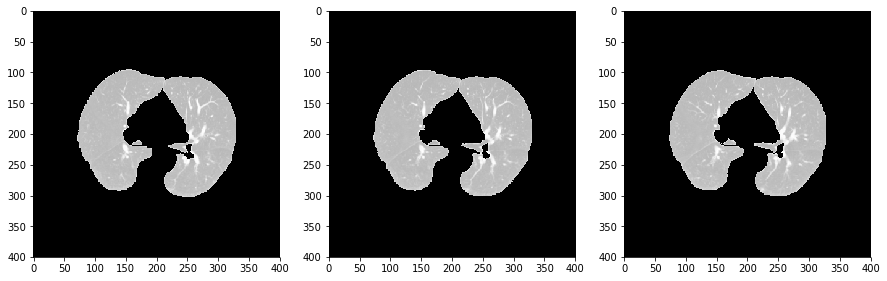

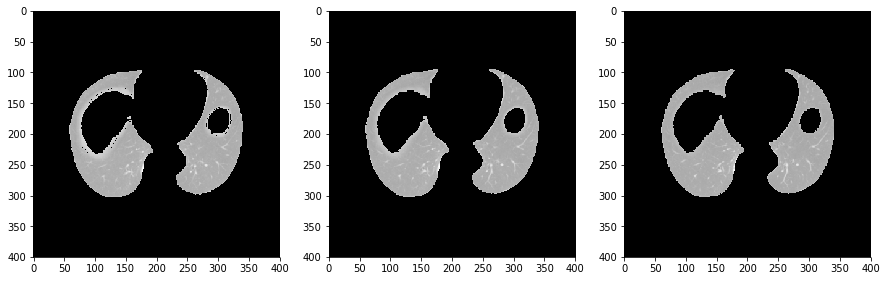

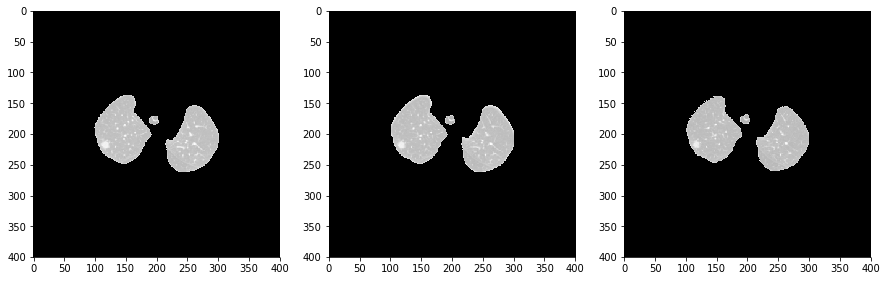

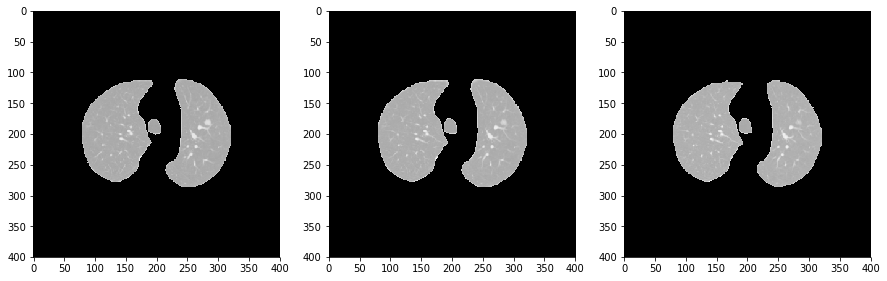

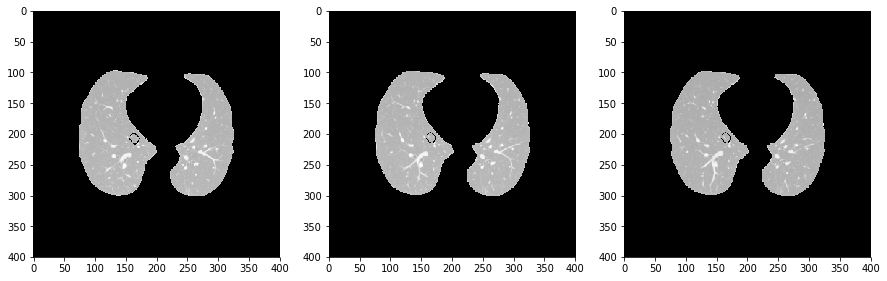

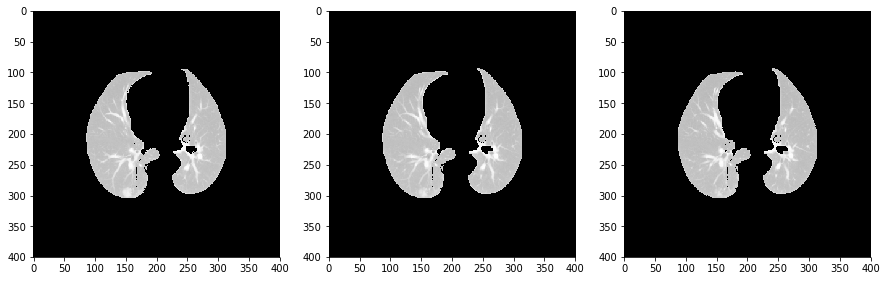

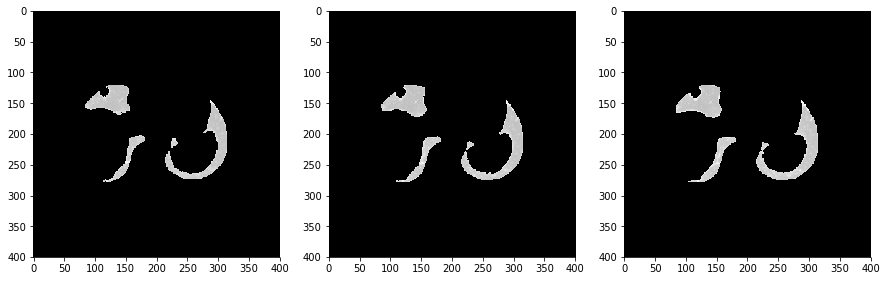

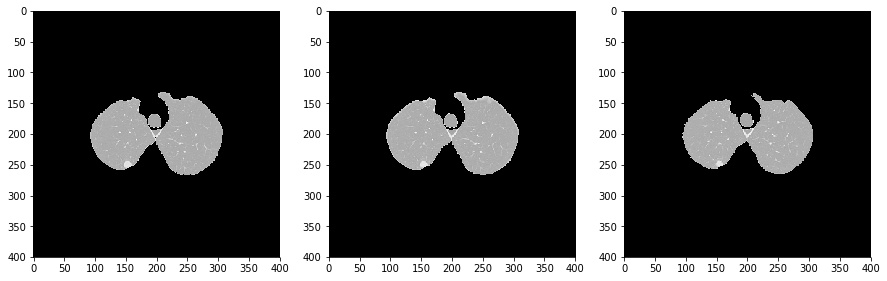

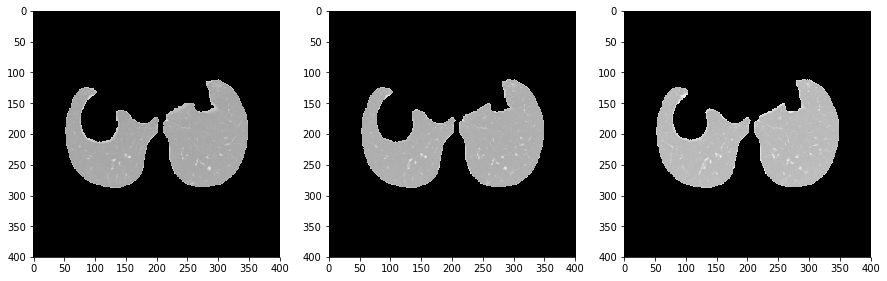

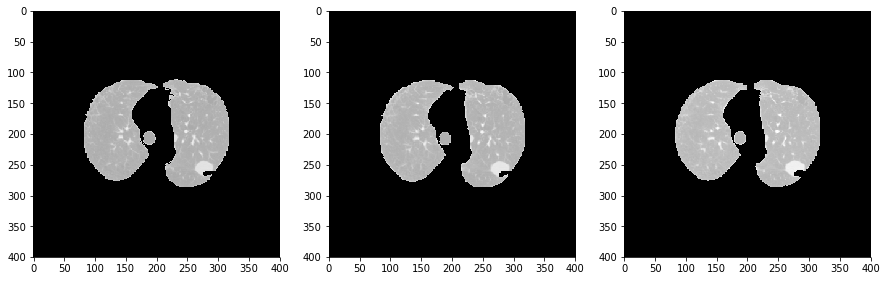

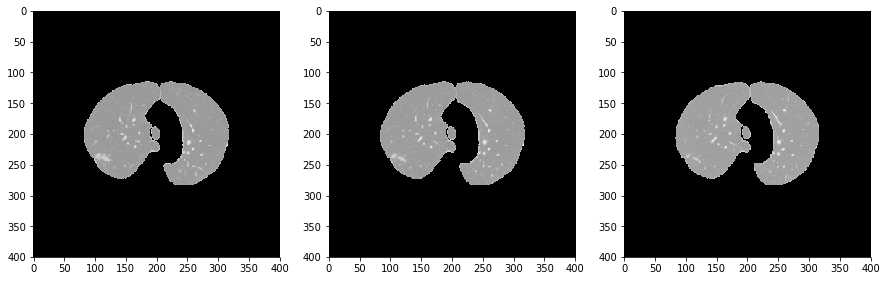

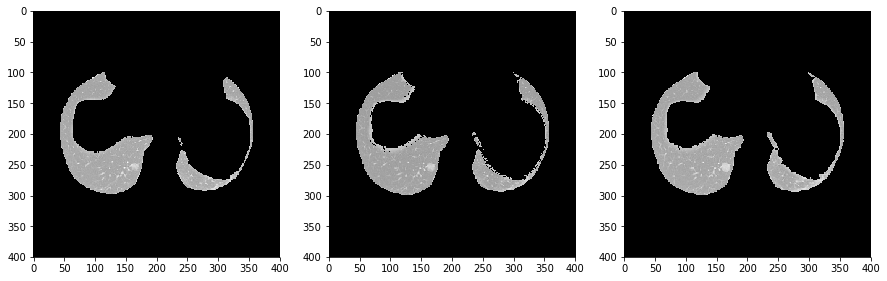

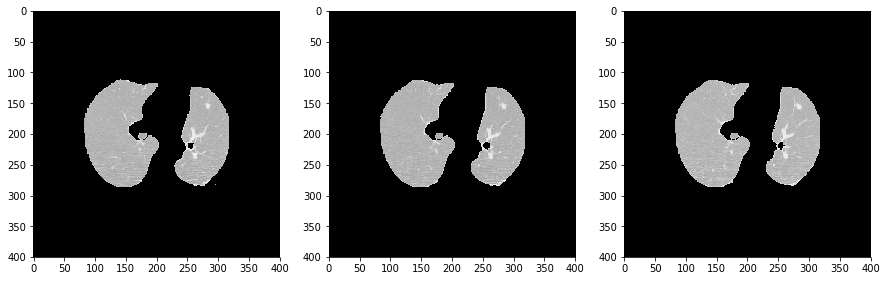

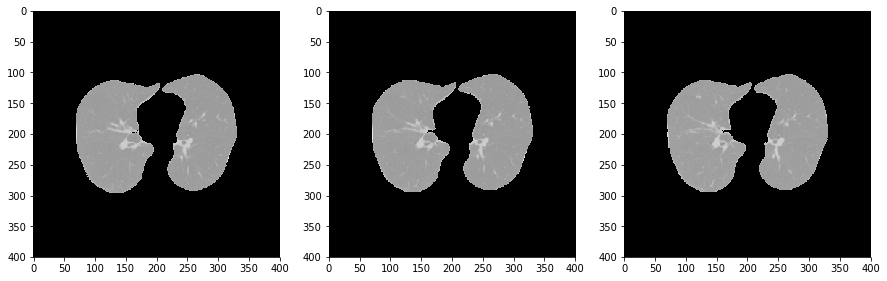

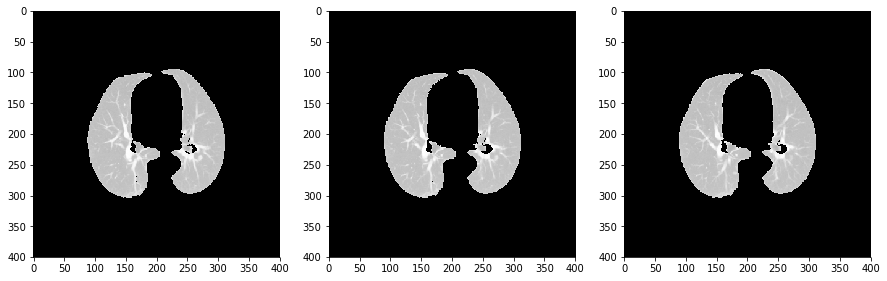

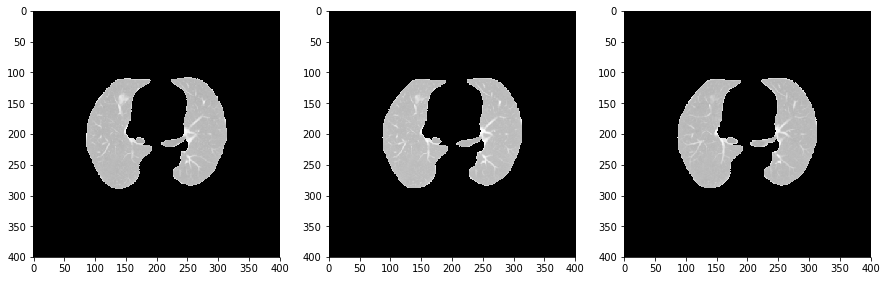

In [10]:
for seq in range(10):
    for n in range(BATCH_SIZE):
        f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,10))
        pre_slc = test_sequence[seq][0][n, :, :, 0]
        slc = test_sequence[seq][0][n, :, :, 1]
        post_slc = test_sequence[seq][0][n, :, :, 2]
        ax1.imshow(pre_slc, cmap="gray")
        ax2.imshow(slc, cmap="gray")
        ax3.imshow(post_slc, cmap="gray")
        plt.show()

In [15]:
df = pd.read_csv(METADATA_CSV_FILE)

In [20]:
df_sag = df[df.plane=='sagittal']
len_sagittal = len(df_sag)
len_iloc = len(df_sag.iloc[int(len_sagittal*0.5):])
len_export = len(df_sag[df_sag.export_idx > int(len_sagittal*0.5)])
print(len_sagittal, len_iloc, len_export)

8121 4061 6772
